

---

# Intro

**Plan**: Import credit card fraud data. Use encoder only transformer network for classifying time series credit card data

**Purpose/Intro**: Task is to develop transformer architecture proof of concept for potential application at work, detecting fraud. In a normal data science project it might be considered best practice to begin with more interpretable models first, for research purposes, but this project is solely for the purpose of assessing the viability of a transformer for this task.

**Hypothesis**: The attention mechanism of the transformer, when combined with an appropriate positional embedding method, is able to capture both long-term and short-term dependencies in time series credit-card fraud data.

**Methodology**: Using cross valdiation techniques on test dataset to calculate appropriate accuracy metrics (adjusting for the significant class imbalance for the dataset), with an aim to assess the viability of transformer networks for fraud classification.





---

# Data Sourcing and Processing



In [ ]:

#import packages:

import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

from google.colab import drive

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  # Check if drive is mounted by looking for the mount point in the file system.
  import os
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

#basics
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#table one
!pip install tableone
from tableone import TableOne

#torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

#sklearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from imblearn.over_sampling import RandomOverSampler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.4 MB/s eta 0:00:00


In [ ]:
data_set_filepath = '/content/drive/MyDrive/Colab_Notebooks/Data/creditcard.feather'

df = pd.read_feather(data_set_filepath)

columns = df.columns.tolist()

print(f"The dataset lenghth is {str(len(df))}")
print(f"The number of columns is {str(len(columns))}")
print(f"The column names are {str(columns)}")
df.head(10)

table1 = TableOne(df, columns=columns, groupby= 'Class', pval=True)
print(table1)

data = df





The dataset lenghth is 284807
The number of columns is 31
The column names are ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
                   Grouped by Class                                                                 
                            Missing            Overall                  0                  1 P-Value
n                                               284807             284315                492        
Time, mean (SD)                   0  94813.9 (47488.1)  94838.2 (47484.0)  80746.8 (47835.4)  <0.001
V1, mean (SD)                     0          0.0 (2.0)          0.0 (1.9)         -4.8 (6.8)  <0.001
V2, mean (SD)                     0          0.0 (1.7)         -0.0 (1.6)          3.6 (4.3)  <0.001
V3, mean (SD)                     0         -0.0 (1.5)          0.0 (1.5)         -7.0 (7.1)  <0.001



---
# Transformer Model



**No HP Tuning**: First we will implement our model without HP tuning and try to overfit, to just prove that we have the generalization power, and just check that we can actually set up and run the architecture

Cuda setup successful
Epoch 1/100 - Train Loss: 0.0048 - Val Loss: 0.0049
Epoch 2/100 - Train Loss: 0.0040 - Val Loss: 0.0051
Epoch 3/100 - Train Loss: 0.0040 - Val Loss: 0.0069
Epoch 4/100 - Train Loss: 0.0038 - Val Loss: 0.0067
Epoch 5/100 - Train Loss: 0.0038 - Val Loss: 0.0069
Epoch 6/100 - Train Loss: 0.0039 - Val Loss: 0.0067
Epoch 7/100 - Train Loss: 0.0037 - Val Loss: 0.0135
Epoch 8/100 - Train Loss: 0.0038 - Val Loss: 0.0067
Epoch 9/100 - Train Loss: 0.0037 - Val Loss: 0.0072
Epoch 10/100 - Train Loss: 0.0037 - Val Loss: 0.0066
Early stopping triggered.


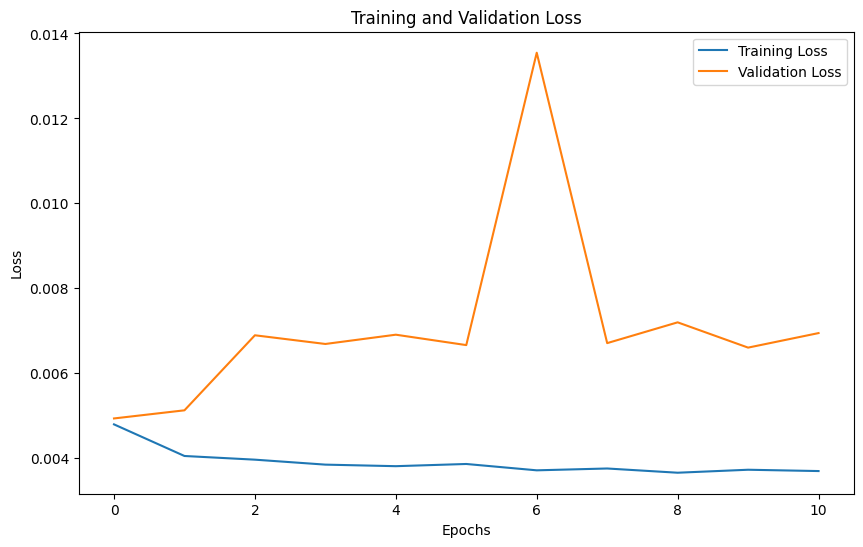

Validation Accuracy: 0.9989
Validation Hit Rate: 0.5974
Validation ROC AUC: 0.9807


In [ ]:
# **Set device for GPU acceleration**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Error warning if no GPU is detected**
if device.type != 'cuda':
    print("WARNING: GPU is not available. The model will run on the CPU, which might be slower.")
else:
    print("Cuda setup successful")

# **Data Preparation**
# Assume `data` is a pandas DataFrame containing your dataset
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (fraud or not)

# **Split data**
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# **Convert to PyTorch tensors**
# Ensure tensors have 3 dimensions by adding a dimension if necessary
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device).unsqueeze(1),
                           torch.tensor(y_train, dtype=torch.float32).to(device))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device).unsqueeze(1),
                         torch.tensor(y_val, dtype=torch.float32).to(device))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device).unsqueeze(1),
                          torch.tensor(y_test, dtype=torch.float32).to(device))

# **DataLoader for batching**
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# **Transformer Model with Batch Normalization and Residual Connections**
class FraudDetectionTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super(FraudDetectionTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)  # Embedding layer
        self.batch_norm = nn.BatchNorm1d(input_dim)  # Batch Normalization before embedding

        # Transformer Encoder Layer with Residual Connections
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,  # Embedding dimension
            nhead=num_heads,  # Number of attention heads
            dim_feedforward=ff_dim,  # Dimension of feedforward network
            dropout=dropout  # Dropout for regularization
        )
        self.transformer = nn.TransformerEncoder(
            self.encoder_layer,
            num_layers=num_layers  # Number of stacked encoder layers
        )

        self.pooling = nn.AdaptiveAvgPool1d(1)  # Global average pooling
        self.fc = nn.Linear(embed_dim, 1)  # Fully connected layer for classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        # Batch normalization and embedding
        x = self.batch_norm(x.squeeze(1))  # Apply BatchNorm and squeeze before embedding
        embedded_x = self.embedding(x).unsqueeze(1)  # Project input to embedding dimension and add sequence dimension

        # Transpose for Transformer (sequence_length, batch_size, embedding_dim)
        embedded_x = embedded_x.permute(1, 0, 2)

        # Pass through the transformer encoder
        # Residual connection: add the input (embedded_x) to the transformer's output
        transformer_output = self.transformer(embedded_x) + embedded_x

        # Global pooling: Average across the sequence length dimension
        pooled_output = self.pooling(transformer_output.permute(1, 2, 0)).squeeze()

        # Fully connected layer for classification
        fc_output = self.fc(pooled_output)
        return self.sigmoid(fc_output)  # Sigmoid activation to get probabilities

# **Training Function with Early Stopping**
def train_model_with_early_stopping(model, train_loader, val_loader, epochs, lr, patience):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        # Early stopping check
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model = model.state_dict()  # Save the best model
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}")

    model.load_state_dict(best_model)  # Load the best model before returning
    return train_losses, val_losses, best_model

# **Validation Metrics Calculation**
def calculate_metrics(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs).squeeze()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    # Convert predictions to binary format for accuracy and hit rate
    y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

    # Metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    hit_rate = np.sum(np.logical_and(np.array(y_true) == 1, np.array(y_pred_binary) == 1)) / np.sum(np.array(y_true) == 1)
    roc_auc = roc_auc_score(y_true, y_pred)

    return accuracy, hit_rate, roc_auc

# **Plotting Function**
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

# **Hyperparameters and Model Initialization**
embed_dim = 128
num_heads = 4
ff_dim = 256
num_layers = 3
dropout = 0.2
epochs = 100
lr = 0.001
patience = 10

model = FraudDetectionTransformer(input_dim=X_train.shape[1], embed_dim=embed_dim,
                                   num_heads=num_heads, ff_dim=ff_dim,
                                   num_layers=num_layers, dropout=dropout)

# **Train the Model**
train_losses, val_losses, best_model = train_model_with_early_stopping(
    model, train_loader, val_loader, epochs, lr, patience
)

# **Plot Losses**
plot_losses(train_losses, val_losses)

# **Validation Metrics**
accuracy, hit_rate, roc_auc = calculate_metrics(model, val_loader)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Hit Rate: {hit_rate:.4f}")
print(f"Validation ROC AUC: {roc_auc:.4f}")




---

# To Do
**Clean data**- reduce noise, identify outliers, greatly upsample minority class (using VAE...?), downsample outliers in majority class perhaps

**Automatically tune HPs** on Transformer network and potentially implement some sort of KFold



---

# Auto commit to github

In [ ]:
import datetime
import os

# Navigate to the repository directory (if not already there)
%cd /content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice

with open('/content/drive/MyDrive/IAM/PAT.txt', 'r') as file:
      github_pat = file.read().strip()
os.environ['GITHUB_PAT'] = github_pat

!git remote add origin "https://github.com/archiegoodman2/machine_learning_practice"

# Replace with your actual username and email (or configure globally)
USERNAME="archiegoodman2"
EMAIL="archiegoodman2011@gmail.com"

# Set global username and email configuration
!git config --global user.name "$USERNAME"
!git config --global user.email "$EMAIL"

now = datetime.datetime.now()
current_datetime = now.strftime("%Y-%m-%d %H:%M")

# Set remote URL using the PAT from environment variable
!git remote set-url origin https://{os.environ['GITHUB_PAT']}@github.com/archiegoodman2/machine_learning_practice.git

# Replace with your desired commit message
COMMIT_MESSAGE = str(current_datetime) + " " + " added residual connections, increased dropout, changed validation metrics, increased epochs "

# Stage all changes
!git add .

# Commit the changes
!git commit -m "$COMMIT_MESSAGE"

# Push to origin
!git push origin master


/content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice
error: remote origin already exists.
[master 5c7b99e] 2024-12-03 21:49 added residual connections, increased dropout, changed validation metrics, increased epochs
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite nn_transformer_creditcardfraud.ipynb (98%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 40.33 KiB | 4.03 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/archiegoodman2/machine_learning_practice.git
   5d3c692..5c7b99e  master -> master
